In [1]:
# imports
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib
from matplotlib import gridspec
%matplotlib inline
import pylab as pl

# define some settings for plots
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.family'] = ['sans-serif']

line_width = 2
color_rna = 'dodgerblue'
color_protein = 'darkorange'
color_phase_space = 'dimgrey'
color_initial_state = 'crimson'
color_steady_state = 'saddlebrown'

# Introduction

In this lecture you will learn some aspects of dynamic modeling applied to biological systems. We will investigate the properties of a simple transcription-translation system and its implications on real biological questions. The language of dynamical models are ordinary differential equations (ODEs). You will learn a bit what they are and how to solve them numerically using python libraries. We will make use of the concept of python functions to solve the same ODEs with differen parameter sets. A function usually looks like this:

```python
def function_name(param_1,param_2):
    some python code...
    to calculate result
    return result
```

In addition to plain python we rely on three libraries for scientific computing and visualisation: NumPy, SciPy and Matplotlib. Probably across this course you came across them already. 

# Simple transcription-translation system modeled by a deterministic ODE system

## Biochemical reactions

In a simple transcription-translation system the RNA of a certain gene is prodcued with a fixed rate $\beta$ and decays with a rate proportional to the curren amount of RNA, a so called first order decay. The protein that our gene is coding for is produced with a rate that is proportional to the current amount of RNA and follows a first order decay as well. A reaction scheme of this small system looks like this:

$$\xrightarrow{\beta} RNA \xrightarrow{\gamma_{m}} o$$ $$RNA \xrightarrow{k} protein$$ $$protein \xrightarrow{\gamma_{p}} o$$

## Deterministic ODE system

The above reaction scheme can be tranlated into two [differential equations](https://en.wikipedia.org/wiki/Differential_equation). For the sake of simplicity we have assumed [mass action kinetics](https://en.wikipedia.org/wiki/Law_of_mass_action) without any saturation effects.

$$ \frac{\mathrm{d}RNA}{\mathrm{d}t} = \beta - \gamma_{m}\cdot RNA$$ 

$$ \frac{\mathrm{d}protein}{\mathrm{d}t} = k\cdot RNA - \gamma_{p} \cdot protein$$

This system of equations describes the rule how the systems state given by the concentration of RNA and protein molecules changes given the current state. The left hand side of the equations are the rate of change and the right hand side the rule how the change depends on the current state. Note that the concentration of RNA appears in both equations, thus the equations are coupled as the amount of proteins depends on the amount of RNA.

To explicitly solve ODEs it is necessary to know the state of the system at one instant of time. Often refered to as the intial conditions and associated with time point $t = 0$. 

We assumed the transcription rate $\beta$ to be constant over time. You can imagine this situation as if at time point zero a transcription factor binds the gene's promoter and activates transcription. For now we will investigate the temporal evolution of the RNA and protein assuming constant transcription, later we will consider the case when transcription is only transiently activated.

### Steady state

The transcription-translation reaches a steady state, i.e. RNA and protein concentrations that do not change over time because the respective production and decay processes balance each other. In steady state the left hand side of the differential equations equals zero and we are left with two algebraic equations that we can solve to calculate the steady state:

**Exercise 1**

Solve the algebraic equations for the steady state: $RNA_{ss}$ and $P_{ss}$.

$$RNA_{ss} = \frac{\beta}{\gamma_{m}}$$

$$P_{ss} = \frac{k\cdot RNA_{ss}}{\gamma_{p}} = \frac{k\beta}{\gamma_{m}\gamma_{p}}$$

The steady state is fully determined by the biochemical reaction rates of our system and here it is a stable state. This means if we move the system out of steady state it will return.

## Analytic solution

The solution of the ODE system with the intital condition $RNA_{0} = protein_{0} = 0$ is given by:

$$ \text{RNA}(t)= RNA_{ss}\big( 1- e^{-\gamma_{m} t}\big)$$

$$\text{protein}(t)= P_{ss}\bigg(1 - \frac{\gamma_{m}e^{-\gamma_{p}t} - \gamma_{m}e^{-\gamma_{p}t}}{\gamma_{m} - \gamma_{p}}\bigg)$$

For the simple ODE system given here it is possible to obtain a analytical solution, in more complex situations this usually is not possible and it is necessary to numerically integrate differential equations. Although we could work here with the analytical solutions we want to go the numerical way. A first impression on how an algorithm could approximate a solution of an ODE gives [Euler method](https://en.wikipedia.org/wiki/Euler_method).

In [2]:
# functions

# numerical solution of the ODE system
def solve_ODE_transcription_translation(x,t,param):
    RNA = x[0]
    protein = x[1]
    
    # define the two coupled ODEs
    dRNA = param[0] - param[1]*RNA
    dprotein = param[2]*RNA - param[3]*protein
    
    # stack the results together into one array with the first row being the RNA and the second the protein
    return np.hstack((dRNA,dprotein))

# analytical solution based on the equations above
def analytic_solution(tt,param):
    # steady state
    RNA_ss = param[0]/param[1]
    p_ss = param[0]/param[1]*param[2]/param[3]
    
    # analytic ODE solution
    RNA = RNA_ss*(1 - sp.exp(-param[1]*tt))
    protein = p_ss*(1 - (param[1]*sp.exp(-param[3]*tt) - param[3]*sp.exp(-param[1]*tt))/(param[1] - param[3]))
    
    return np.vstack((RNA,protein))

(0, 11.0)

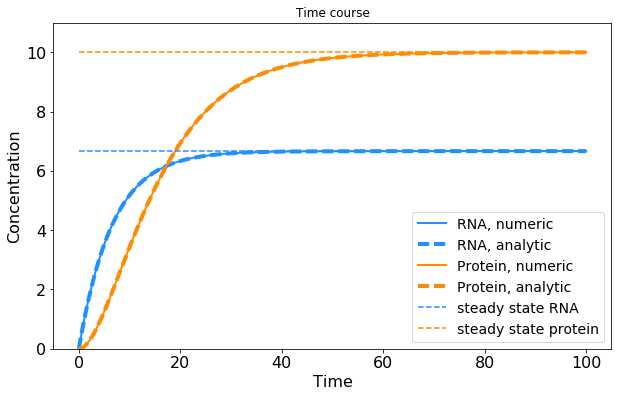

In [3]:
# define parameters and time vector to solve the ODEs
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 0
protein_0 = 0
y_0 = [RNA_0,protein_0]

# set the time vector
tt = sp.linspace(0,100,200)

# solve the ODE system with the defined parameters and initial condition
sol_deterministic = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

# calculate the analytic solution
analytic = analytic_solution(tt,param)

# plot the result
fig,ax = pl.subplots(1,1, figsize = (10,6))
ax.plot(tt,sol_deterministic[:,0], label = 'RNA, numeric', lw = line_width,color = color_rna)
ax.plot(tt,analytic[0],'--',lw = 2*line_width, color = color_rna, label = 'RNA, analytic')
ax.plot(tt,sol_deterministic[:,1], label = 'Protein, numeric', lw = line_width, color = color_protein)
ax.plot(tt,analytic[1],'--',lw = 2*line_width, color = color_protein, label = 'Protein, analytic')
ax.plot(tt,np.zeros(len(tt)) + steady_state_RNA,'--',color = color_rna,label = 'steady state RNA')
ax.plot(tt,np.zeros(len(tt)) + steady_state_protein,'--',color = color_protein, label = 'steady state protein')
ax.legend(loc = 'best')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Time course')
ax.set_ylim(0,steady_state_protein+steady_state_protein*0.1)

## Influence of the RNA and protein decay rates on the time to reach the steady state

**Exercise 2**

Please try the effects of different combinations of RNA and protein rates on the kinetics of our small transcription ans translation system by changing the parameters ```gamma_m``` and ```gamma_p``` in the code example below. 

Reference parameters:

- $\beta = 1$
- $\gamma_{m} = 0.15$
- $k = 0.15$
- $\gamma_{p} = 0.1$

**Questions**
- Which rate(s) influence the steady state?
- Which rate(s) influence the kinetics, i.e. how fast the steady state is reached?

**Instructions**
- Below you see a plot of the same simulations as above, use them as references. Create a new simulation were you change the parameters ```beta, gamma_m``` and ```gamma_p```. Leave the translation rate ```k``` fixed.
- Add your results into the plot below the reference simulation and investigate the influence of the different parameters


/Users/stephan/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


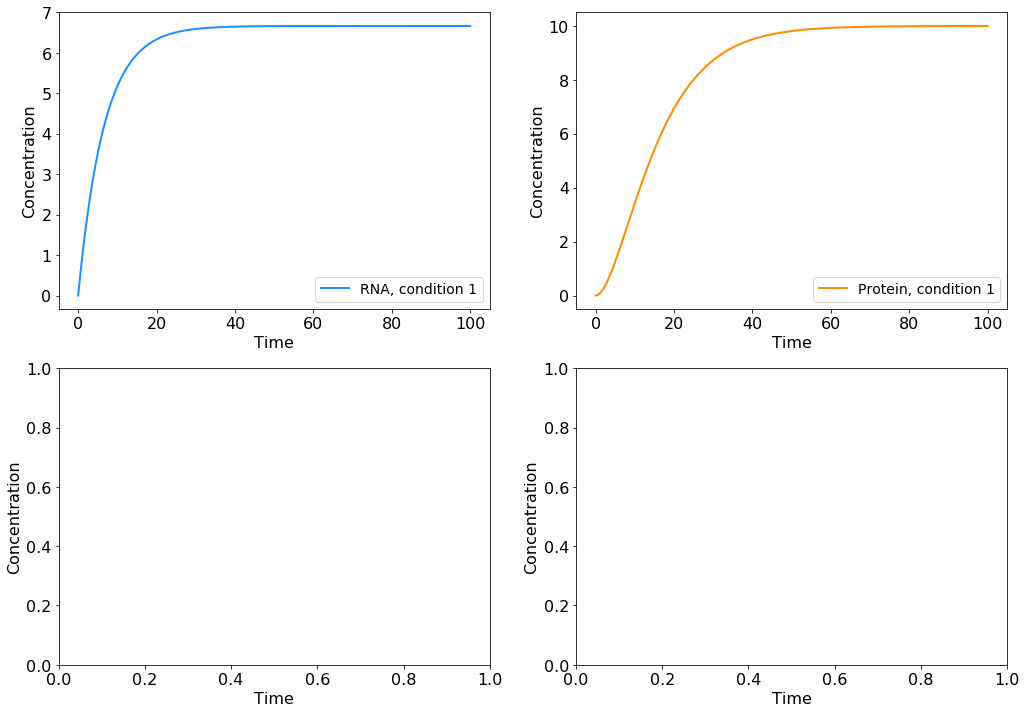

In [4]:
# define intial conditions
RNA_0 = 0
protein_0 = 0
y_0 = [RNA_0,protein_0]

# set the time vector
tt = sp.linspace(0,100,200)

#--------------------------------

# I) define parameters and time vector to solve the ODEs (Reference parameters)
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# solve the ODE system with the defined parameters and initial condition
sol_deterministic = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

#---------------------------------

# II) define parameters and time vector to solve the ODEs (Perturbed parameters)
# beta = 1
# gamma_m = 0.15
# k = 0.15
# gamma_p = 0.1
# param1 = [beta,gamma_m,k,gamma_p]

# # solve the ODE system with the defined parameters and initial condition
# sol_deterministic1 = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param1,))

#---------------------------------

# plot the result
fig,ax = pl.subplots(2,2, figsize = (17,12))
ax[0,0].plot(tt,sol_deterministic[:,0], label = 'RNA, condition 1', lw = line_width,color = color_rna)

ax[0,0].legend(loc = 'best')
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Concentration')

ax[0,1].plot(tt,sol_deterministic[:,1], label = 'Protein, condition 1', lw = line_width, color = color_protein)
ax[0,1].legend(loc = 'best')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Concentration')

ax[1,0]#.plot(tt,sol_deterministic1[:,0], label = 'RNA, condition 2', lw = line_width,color = color_rna)
ax[1,0].legend(loc = 'best')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Concentration')

ax[1,1]#.plot(tt,sol_deterministic1[:,1], label = 'Protein, condition 2', lw = line_width, color = color_protein)
# ax[1,1].legend(loc = 'best')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Concentration')

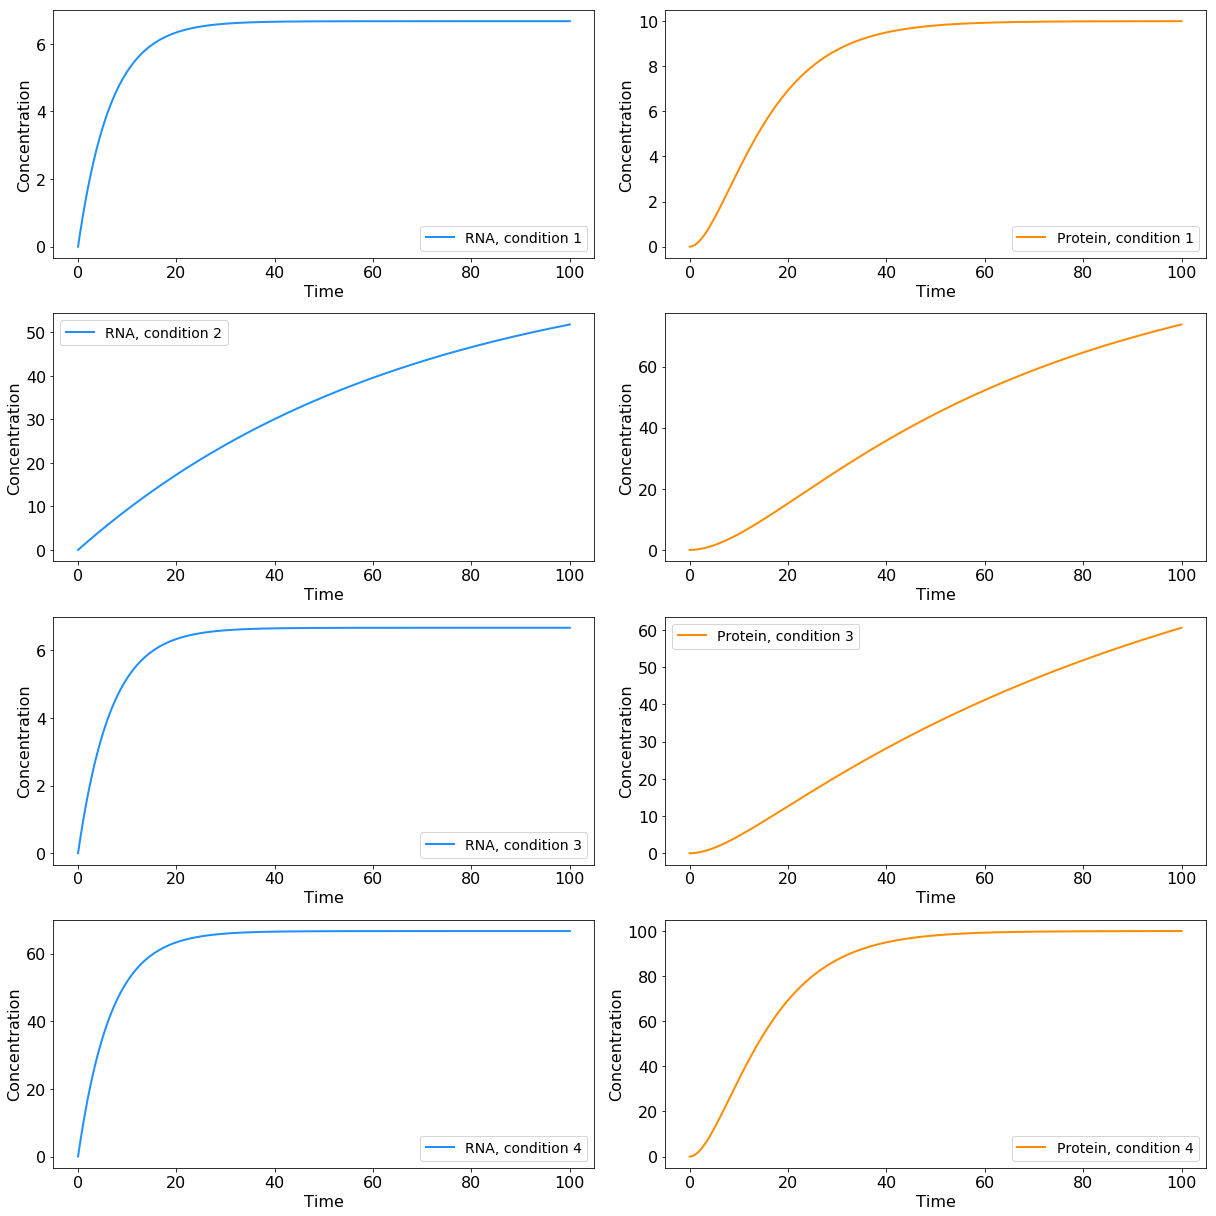

In [5]:

# define intial conditions
RNA_0 = 0
protein_0 = 0
y_0 = [RNA_0,protein_0]

# set the time vector
tt = sp.linspace(0,100,200)

#--------------------------------

# I) define parameters and time vector to solve the ODEs (Reference parameters)
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# solve the ODE system with the defined parameters and initial condition
sol_deterministic = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

#---------------------------------

# II) define parameters and time vector to solve the ODEs (Perturbed parameters, RNA decay)
beta = 1
gamma_m = 0.015
k = 0.15
gamma_p = 0.1
param1 = [beta,gamma_m,k,gamma_p]

# solve the ODE system with the defined parameters and initial condition
sol_deterministic1 = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param1,))

#---------------------------------
# III) define parameters and time vector to solve the ODEs (Perturbed parameters, protein decay)
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.01
param1 = [beta,gamma_m,k,gamma_p]

# solve the ODE system with the defined parameters and initial condition
sol_deterministic2 = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param1,))

#---------------------------------
# I) define parameters and time vector to solve the ODEs (Reference parameters)
beta = 10
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# solve the ODE system with the defined parameters and initial condition
sol_deterministic3 = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

#---------------------------------

# plot the result
fig,ax = pl.subplots(4,2, figsize = (17,17))
ax[0,0].plot(tt,sol_deterministic[:,0], label = 'RNA, condition 1', lw = line_width,color = color_rna)

ax[0,0].legend(loc = 'best')
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Concentration')

ax[0,1].plot(tt,sol_deterministic[:,1], label = 'Protein, condition 1', lw = line_width, color = color_protein)
ax[0,1].legend(loc = 'best')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Concentration')

ax[1,0].plot(tt,sol_deterministic1[:,0], label = 'RNA, condition 2', lw = line_width,color = color_rna)
ax[1,0].legend(loc = 'best')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Concentration')

ax[1,1].plot(tt,sol_deterministic1[:,1], label = 'Protein, condition 2', lw = line_width, color = color_protein)
# ax[1,1].legend(loc = 'best')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Concentration')

ax[2,0].plot(tt,sol_deterministic2[:,0], label = 'RNA, condition 3', lw = line_width,color = color_rna)
ax[2,0].legend(loc = 'best')
ax[2,0].set_xlabel('Time')
ax[2,0].set_ylabel('Concentration')

ax[2,1].plot(tt,sol_deterministic2[:,1], label = 'Protein, condition 3', lw = line_width, color = color_protein)
ax[2,1].legend(loc = 'best')
ax[2,1].set_xlabel('Time')
ax[2,1].set_ylabel('Concentration')

ax[3,0].plot(tt,sol_deterministic3[:,0], label = 'RNA, condition 4', lw = line_width,color = color_rna)
ax[3,0].legend(loc = 'best')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel('Concentration')

ax[3,1].plot(tt,sol_deterministic3[:,1], label = 'Protein, condition 4', lw = line_width, color = color_protein)
ax[3,1].legend(loc = 'best')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel('Concentration')


pl.tight_layout()

Let's test the effect of the protein decay rates on the systems kinetcs. This time we define a set of decay rates, keep the steady state fixed by adjusting the potein production rate $k$ and then iterate over the defined rates in a for loop.

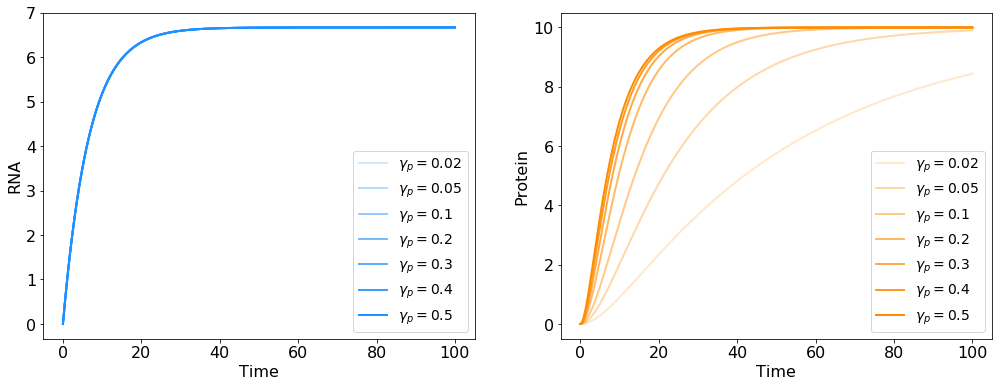

In [6]:
# range of protein decay rates
GAMMA_p = np.array([0.02,0.05,0.1,0.2,0.3,0.4,0.5])
k = GAMMA_p * steady_state_protein / steady_state_RNA

beta = 1
gamma_m = 0.15

tt = sp.linspace(0,100,1000)
sol = []
for ii,gamma_p in enumerate(GAMMA_p):
    param = [beta,gamma_m,k[ii],gamma_p]
    s = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))
    sol.append(s)
    
# plot results
fig,ax = pl.subplots(1,2,figsize = (17,6))
alpha = sp.linspace(0.2,1,len(sol))
for ii,ss in enumerate(sol):
    ax[0].plot(tt,ss[:,0],lw = line_width, color = color_rna, alpha = alpha[ii], 
               label = '$\gamma_{p} = $'+str(GAMMA_p[ii]))
    
    ax[1].plot(tt,ss[:,1],lw = line_width, color = color_protein, alpha = alpha[ii], 
               label = '$\gamma_{p} = $'+str(GAMMA_p[ii]))

ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('RNA')

ax[1].legend(loc = 'best')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Protein')

The time to reach half steady state provides a measure for the response time of the system. The response time of the RNA depends only on RNA decay and can be calculated as:

$$\tau_{1/2, RNA} = \frac{\ln 2}{\gamma_{m}}$$

As the plots above indicate the response time of the protein depends on both decay rates $\gamma_{m}$ and $\gamma_{p}$. The time to reach steady state is determined by

$$ \frac{\gamma_{m}e^{-\gamma_{p}t} - \gamma_{p}e^{-\gamma_{m}t}}{\gamma_{m} - \gamma_{p}} - \frac{1}{2} = 0$$

Unfortunately this equation cannont be solve for $t$ analytically, thus, we have to turn to a numerics using the ```fsolve``` function from scipy.

In [7]:
# function that calculates the RHS of the above equation for a given set of gamma_m & gamma_p & t
def response_time(t,decay):
    return (decay[0]*sp.exp(-decay[1]*t) - decay[1]*sp.exp(-decay[0]*t))/(decay[0] - decay[1]) - 0.5

In [8]:
# we want to find the value t for a given pair gamma_m & gamma_p that solves the above equation, 
# i.e. the RHS equals 0

decay = [0.02,0.01]
resp = fsolve(response_time,1,args = (decay,))
print(resp)

[ 122.79471773]


/Users/stephan/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/stephan/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


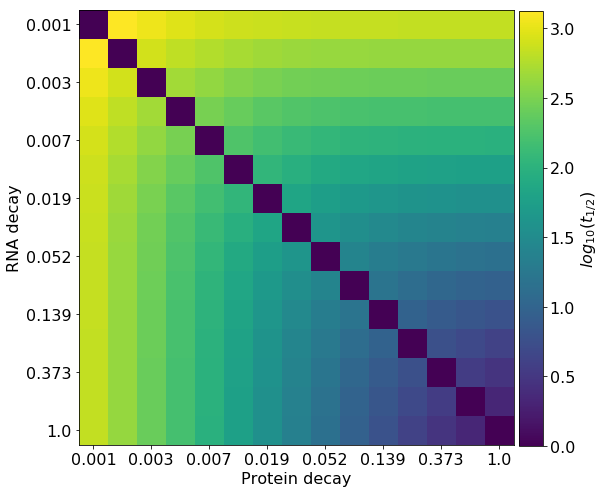

In [9]:
# define sets of decay rates and estimate the protein response time using a nested for loop
steps = 15
GAMMA_m = sp.logspace(-3,0,steps)
GAMMA_p = sp.logspace(-3,0,steps)

initial_guess = 1
res = np.zeros((len(GAMMA_m),len(GAMMA_p)))
for ii,gamma_m in enumerate(GAMMA_m):
    for jj,gamma_p in enumerate(GAMMA_p):
        decay = [gamma_m,gamma_p]
        t_12 = fsolve(response_time,initial_guess,args = (decay,))
        res[ii,jj] = t_12[0]

res = sp.log10(res)
    
# visualise the results as a colormap
fig,ax = pl.subplots(1,1, figsize = (8,8))
cax = ax.imshow(res)
cbar = fig.add_axes([0.9, 0.123, 0.04, 0.755])
fig.colorbar(cax, cax = cbar, orientation = "vertical")
cbar.set_ylabel('$log_{10}(t_{1/2})$')
ticks = np.arange(0,steps,2)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_yticklabels(np.round(GAMMA_m[ticks],3))
ax.set_xticklabels(np.round(GAMMA_p[ticks],3))
ax.set_ylabel('RNA decay')
ax.set_xlabel('Protein decay')

## Transient activation of gene transcription

Now we will investigate the case when gene transcription is only transiently activated by a transcription factor which in turn might me activated by a external stimulus. The biological scenario is that the transcription factor remains at the promoter only for a certain amount of time. Mathematically this means that the transcription rate is a function of time $\beta = \beta(t)$. We assume the functional relation for $\beta$ to be:

$$\beta(t) = \beta\cdot e^{-k_1 t}\cdot (1 - e^{-k_{2}t})$$

In [10]:
# functions
def TF_binding(param,tt):
    k_1,k_2 = param[0],param[1]
    return sp.exp(-k_1*tt)*(1-sp.exp(-k_2*tt))

# ODE system with time varying transcription rate
def solve_ODE_time_dependent_transcription(x,t,param,param_binding):
    RNA = x[0]
    
    dRNA = param[0]*TF_binding(param_binding,t) - param[1]*RNA
    
    return dRNA

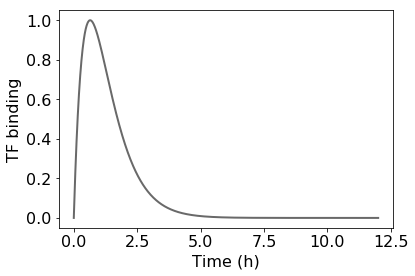

In [11]:
# visualize the TF binding pattern
k_1 = 1.5
k_2 = 0.1
param_binding = [k_1,k_2]
tt = sp.linspace(0,12,1000)
binding = TF_binding(param_binding,tt)
binding = binding/binding.max()

fig,ax = pl.subplots(1,1, figsize = (6,4))
ax.plot(tt,binding, lw = line_width, color = color_phase_space)
ax.set_ylabel('TF binding')
ax.set_xlabel('Time (h)')

**Exercise 3**

Tune the RNA decay rate to create different behaviour of the RNA time courses. Try to resemble the following expression characteristics:
- fast and transient (cluster I)
- slow and sustained (cluster III)
- intermediate behaviour (cluster II)

as in the example from the paper. Use the example given below to create new simulations and add the results to the plot.

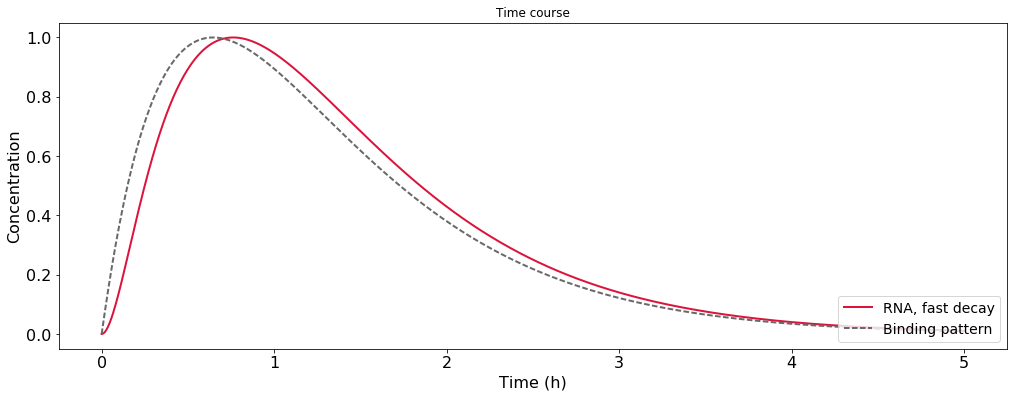

In [12]:
# define the binding pattern
k_1 = 1.5
k_2 = 0.1
param_binding = [k_1,k_2]
tt = sp.linspace(0,5,1000)

binding = TF_binding(param_binding,tt)
binding = binding/binding.max()

y_0 = 0

# global transcription rate
beta = 1

#-----------------------------

# fast RNA decay
gamma_m = 10
param = [beta,gamma_m]

# solve the ODE system
sol_fast = odeint(solve_ODE_time_dependent_transcription,y_0,tt,args = (param,param_binding))
sol_fast = sol_fast/sol_fast[:,0].max()
# -----------------------------

# plot the result
fig,ax = pl.subplots(1,1, figsize = (17,6))

ax.plot(tt,sol_fast[:,0], label = 'RNA, fast decay', lw = line_width, color = color_initial_state)
ax.plot(tt,binding,'--',lw = line_width,color = color_phase_space,label = 'Binding pattern')
ax.legend(loc = 'lower right')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Concentration')
ax.set_title('Time course')
# ax[0].set_ylim(0,steady_state_protein+steady_state_protein*0.1)


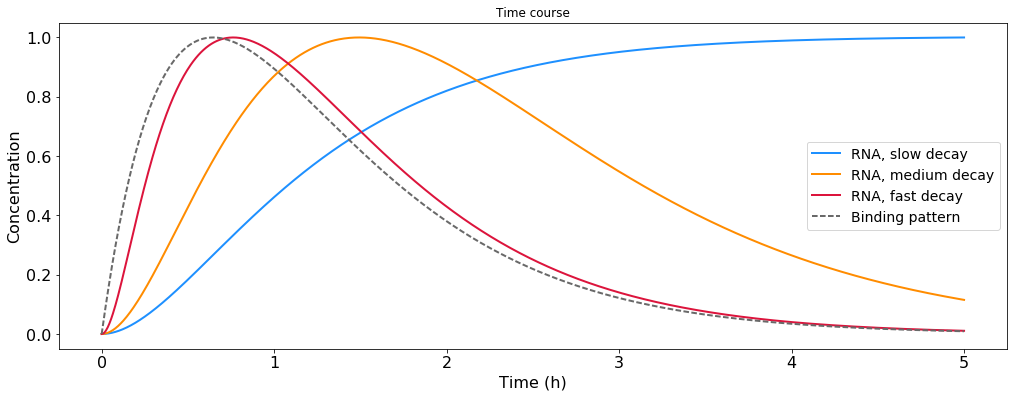

In [13]:
# delete for the student version

# define the binding pattern
k_1 = 1.5
k_2 = 0.1
param_binding = [k_1,k_2]
tt = sp.linspace(0,5,1000)

binding = TF_binding(param_binding,tt)
binding = binding/binding.max()

y_0 = 0

# global parameters of transcription, translation and protein decay
beta = 1

#-----------------------------

# fast RNA decay
gamma_m = 10
param = [beta,gamma_m]

# solve the ODE system
sol_fast = odeint(solve_ODE_time_dependent_transcription,y_0,tt,args = (param,param_binding))
sol_fast = sol_fast/sol_fast[:,0].max()
 
#-----------------------------

# medium RNA decay
gamma_m = 1
param = [beta,gamma_m]

# solve the ODE system
sol_medium = odeint(solve_ODE_time_dependent_transcription,y_0,tt,args = (param,param_binding))
sol_medium = sol_medium/sol_medium[:,0].max()
#-----------------------------

# slow RNA decay
gamma_m = 0.001
param = [beta,gamma_m]

# solve the ODE system
sol_slow = odeint(solve_ODE_time_dependent_transcription,y_0,tt,args = (param,param_binding))
sol_slow = sol_slow/sol_slow[:,0].max()
#----------------------------

# plot the result
fig,ax = pl.subplots(1,1, figsize = (17,6))
ax.plot(tt,sol_slow[:,0], label = 'RNA, slow decay', lw = line_width,color = color_rna)
ax.plot(tt,sol_medium[:,0], label = 'RNA, medium decay', lw = line_width, color = color_protein)
ax.plot(tt,sol_fast[:,0], label = 'RNA, fast decay', lw = line_width, color = color_initial_state)
ax.plot(tt,binding,'--',lw = line_width,color = color_phase_space,label = 'Binding pattern')
ax.legend(loc = 'best')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Concentration')
ax.set_title('Time course')
# ax[0].set_ylim(0,steady_state_protein+steady_state_protein*0.1)


## Correlation between RNA and protein abundance depends on the RNA decay rate

**Exercise 4**
Investigate the correlation between RNA and protein levels. 
- Plot RNA and protein levels agains each other
- You can use simulations you have created earlier for a step like increase in RNA synthesis (Exercise 2)

**Questions**
- Under what conditions RNA and protein are strongly correlated

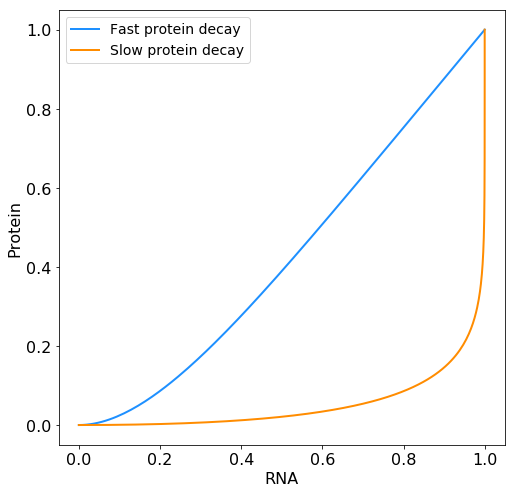

In [14]:
fig,ax = pl.subplots(1,1, figsize = (8,8))

ax.plot(sol_deterministic1[:,0]/sol_deterministic1[:,0].max(),sol_deterministic1[:,1]/sol_deterministic1[:,1].max(),
       label = 'Fast protein decay', lw = line_width, color = color_rna)
ax.plot(sol_deterministic2[:,0]/sol_deterministic2[:,0].max(),sol_deterministic2[:,1]/sol_deterministic2[:,1].max(),
       label = 'Slow protein decay', lw = line_width, color = color_protein)

ax.set_ylabel('Protein')
ax.set_xlabel('RNA')
ax.legend(loc = 'best')

# Circadian oscillations as an example of negative feedback

Circadian oscillations are our daily rhythms: activity, metabolism, sleep, etc. They are controlled by multiple genes that influence each other. The simple transcription-translation system that we were investigating so far is not able to create oscillations. For sustained oscillation we need negative feedback. This means that the protein acts back on its own transcription as a supressor. A second important ingredient to create oscillations is a time delay, thus, the feedback of the protein (here _Per1_) acts not instantaneous but with some delay. The protein _Per1_ exists in two forms here indicated as $protein$ and $protein_p$ which supresses its own transcription but first it has to be created which generates the delay. 

Here are the differential equations describing the negative feedback loop of _Per1_ on its own transcription. The feedback on the RNA prodiction is mediated by a special input function, a so called Hill-Function. A sigmoidal function, i.e. the effect of the feedback saturates and does not become arbitrarily large. The Hill-Coefficient $n$ describes the steepness of the Hill-Function. We will see during the investigation of the system that $n$ plays a cruicial role and that it has to pass a minimal threshold to obtain undampened oscillations.

$$\frac{dRNA}{dt} = k_{1}\frac{K_{i}^{n}}{K_{i}^{n} + protein_{p}^{n}} - k_{2} RNA $$

$$\frac{dprotein}{dt} = k_{3} RNA - k_4 protein$$

$$\frac{dprotein_{p}}{dt} = k_{5}protein - k_{6}protein_{p}$$

**Exercise 5**

On the example of the function implementing the simple transcription-translation ODE system try to write your own function to numerically solve the three ODEs resembling a circadian oscillator. 

- Name it 'circadian_ODEs'
- it needs three input values: 
    - an array _x_ for the actual values of the RNA and proteins
    - the time vector _t_ 
    - a vector _param_ with the kinetic parameters. 
- You can solve the ODE system as before by calling the ```odeint``` function, you have to hand over the initial conditions, the predefined time vector and the parameter vector.

In [15]:
def circadian_ODEs(x,t,param):
    k_1,k_2,k_3,k_4,k_5,k_6,K_i,n = param[0],param[1],param[2],param[3],param[4],param[5],param[6],param[7]
    
    RNA = x[0]
    protein = x[1]
    protein_p = x[2]
    
    # delete RHS in student version
    dRNA = k_1 * K_i**n/(K_i**n + protein_p**n) - k_2*RNA
    dprotein = k_3*RNA - k_4*protein
    dprotein_p = k_5*protein - k_6*protein_p
    
    return np.hstack((dRNA,dprotein,dprotein_p))

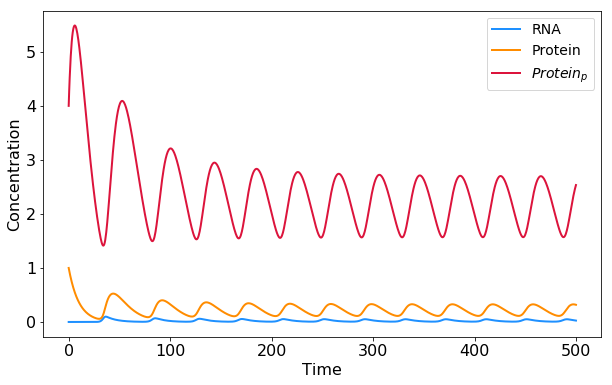

In [16]:
# define parameters
k_1 = 1
k_2 = 0.1
k_3 = 1
k_4 = 0.1
k_5 = 1
k_6 = 0.1
K_i = 1
n = 10

param = [k_1,k_2,k_3,k_4,k_5,k_6,K_i,n]

# define an intital state
RNA_0 = 0
protein_0 = 1
protein_p_0 = 4
y_0 = [RNA_0,protein_0,protein_p_0]

tt = sp.linspace(0,500,1000)

# use odeint and your function to generate simulations 
sol_circ = odeint(circadian_ODEs,y_0,tt,args = (param,))

fig,ax = pl.subplots(1,1, figsize = (10,6))

ax.plot(tt,sol_circ[:,0], lw = line_width, color = color_rna, label = 'RNA')
ax.plot(tt,sol_circ[:,1], lw = line_width, color = color_protein, label = 'Protein')
ax.plot(tt,sol_circ[:,2], lw = line_width, color = color_initial_state, label = '$Protein_{p}$')
ax.legend(loc = 'best')
ax.set_ylabel('Concentration')
ax.set_xlabel('Time')

## Effect of the protein decay rates on the oscillation frequency

**Exercise 6**
Change the protein decay rates to ```k_4 = k_6 = 0.2```

**Exercise 7** 
Change cooperativity factor to ```n = 3```

**Questions**
- What is the effect on the oscillation period?
- What is the effect on the dampening of the oscillations?

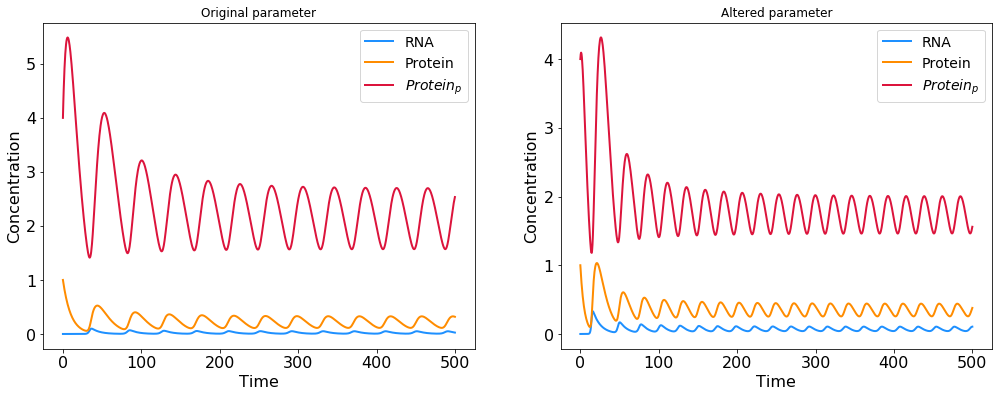

In [17]:
# define a second set of parameters with altered decay rates
k_1 = 1
k_2 = 0.1
k_3 = 1
k_4 = 0.2
k_5 = 1
k_6 = 0.2
K_i = 1
n = 10

param = [k_1,k_2,k_3,k_4,k_5,k_6,K_i,n]

sol_circ_fast = odeint(circadian_ODEs,y_0,tt,args = (param,))

fig,ax = pl.subplots(1,2, figsize = (17,6))

ax[0].plot(tt,sol_circ[:,0], lw = line_width, color = color_rna, label = 'RNA')
ax[0].plot(tt,sol_circ[:,1], lw = line_width, color = color_protein, label = 'Protein')
ax[0].plot(tt,sol_circ[:,2], lw = line_width, color = color_initial_state, label = '$Protein_{p}$')
ax[0].legend(loc = 'best')
ax[0].set_ylabel('Concentration')
ax[0].set_xlabel('Time')
ax[0].set_title('Original parameter')

ax[1].plot(tt,sol_circ_fast[:,0], lw = line_width, color = color_rna, label = 'RNA')
ax[1].plot(tt,sol_circ_fast[:,1], lw = line_width, color = color_protein, label = 'Protein')
ax[1].plot(tt,sol_circ_fast[:,2], lw = line_width, color = color_initial_state, label = '$Protein_{p}$')
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_title('Altered parameter')

## A high cooperativity is necessary to achive undampened oscillations

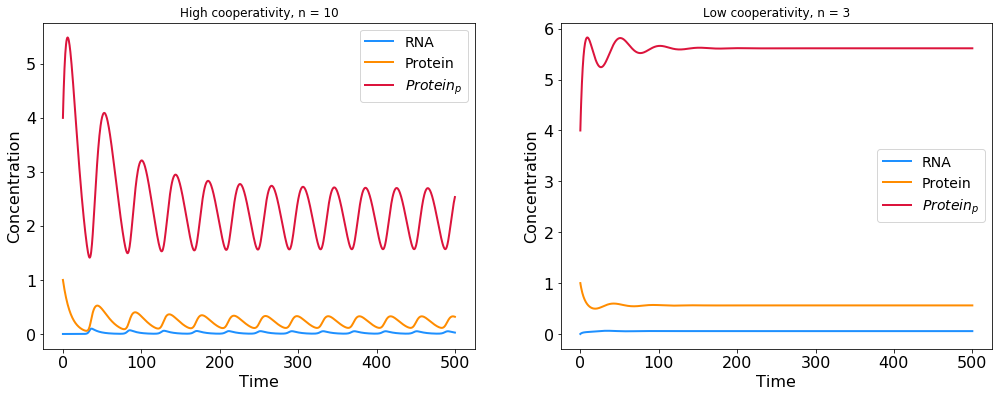

In [18]:
# define parameters
k_1 = 1
k_2 = 0.1
k_3 = 1
k_4 = 0.1
k_5 = 1
k_6 = 0.1
K_i = 1

# alter the hill-coefficient to see the effect of high an low cooperativity
n = 3

param = [k_1,k_2,k_3,k_4,k_5,k_6,K_i,n]

sol_circ_cooperativity = odeint(circadian_ODEs,y_0,tt,args = (param,))

fig,ax = pl.subplots(1,2, figsize = (17,6))

ax[0].plot(tt,sol_circ[:,0], lw = line_width, color = color_rna, label = 'RNA')
ax[0].plot(tt,sol_circ[:,1], lw = line_width, color = color_protein, label = 'Protein')
ax[0].plot(tt,sol_circ[:,2], lw = line_width, color = color_initial_state, label = '$Protein_{p}$')
ax[0].legend(loc = 'best')
ax[0].set_ylabel('Concentration')
ax[0].set_xlabel('Time')
ax[0].set_title('High cooperativity, n = 10')

ax[1].plot(tt,sol_circ_cooperativity[:,0], lw = line_width, color = color_rna, label = 'RNA')
ax[1].plot(tt,sol_circ_cooperativity[:,1], lw = line_width, color = color_protein, label = 'Protein')
ax[1].plot(tt,sol_circ_cooperativity[:,2], lw = line_width, color = color_initial_state, label = '$Protein_{p}$')
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Concentration')
ax[1].set_xlabel('Time')
ax[1].set_title('Low cooperativity, n = '+str(n))

# Transcription-translation system modeled as stochastic system: single cell behaviour

Biochemical interactions in single cells can be random. For instance, various transcription factors are present in cells only in hundreds to thousands of copies, which is not much considering the size of the genome and that each gene is usually present in two alleles only. Such low copy numbers can create strong stochastic effects on the single cell level. In this part of the lecture we want to briefly dig into its implications. We use a so called Monte Carlo algorithm to simulate stochastic realistations of our transcription-translation system. We will test the effects of different parameter values on temporal fluctuations.

## The stochastic simulation algorithm

Developed mainly by Daniel Gillespie. The algorithm simulates the stochastic biochemical interactions of the reacting species, here RNA and protein, based on the current amount molecules of each species and the rates of the possible reactions. The algorithm essentially is a loop and in each iteration the next reaction that happens and the time point of the reaction are simulated based on random number generation. A deeper explanation of the algorithm can be found on [wikipedia](https://en.wikipedia.org/wiki/Gillespie_algorithm) or in the original publications of [D. Gillespie](http://pubs.acs.org/doi/abs/10.1021/j100540a008). [Here](https://www.ncbi.nlm.nih.gov/pubmed/17037977) you can find a comprehensible review of the algorithm, it's foundations and possible approximate implementations.

In contrast to the deterministic ODE system above the amount of RNA and protein now is not measured in concentrations but in the number of molecules of each species. The systems state is defined by the set of molecule counts. During each iteration of the algorithm the systems state is update according to the sampled reaction.

The system consists of four different reactions:

1. **RNA production:** $ RNA \xrightarrow{\beta} RNA + 1$
2. **RNA decay:** $RNA \xrightarrow{\gamma_{m}\cdot RNA} RNA - 1$
3. **Protein production:** $protein \xrightarrow{k\cdot RNA} protein + 1$
4. **Protein decay:** $protein \xrightarrow{\gamma_{p}\cdot protein} protein - 1$

The likelihood of each reaction depends of the current state of the system, i.e. the number of present RNA and protein molecules.

The **steady state** of the stochastic system is the same as for the deterministic ODE system. However, now we will observe fluctuations around the steady state. The characteristics of this fluctuations are controlled by the reaction rates. Time course measurements of fluctuations around the steady state allow to estimate the kinetic reaction rates which would not be for the ODE system.

In [19]:
# implementation of the Gillespie algorithm to simulate the stochastic transcription-tranlsation system
def stoch_sim_transcription_translation(param,initial_state,tf):
    beta,gamma_m,k,gamma_p = param[0],param[1],param[2],param[3]
    
    # reaction matrix, the systems state includes the time points of the reactions in the first column
    reactions = np.array([[0,1,0],
                         [0,-1,0],
                         [0,0,1],
                         [0,0,-1]])
    
    # initialise the systems state
    state = np.zeros(3)
    state[1] = initial_state[0]
    state[2] = initial_state[1]
    STATE = state
    
    tt = 0
    while tt <= tf:
        # sample two random numbers uniformly between 0 and 1
        rr = sp.random.uniform(0,1,2)
        
        a_0 = beta + gamma_m*state[1] + k*state[1] + gamma_p*state[2]    
        a_s = np.array([beta,gamma_m*state[1],k*state[1],gamma_p*state[2]],dtype = float)
                    
        # time step 
        tt = tt + 1. / a_0 * sp.log(1. / rr[0])
        state[0] = tt
        
        # find the next reaction
        prop = rr[1] * a_0
        cum_a_s = np.cumsum(a_s)
        
        ind = np.where(prop <= cum_a_s)[0][0]
        
        # update the systems state
        state = state+reactions[ind]
        
        STATE = np.vstack((STATE,state))
    
    return STATE

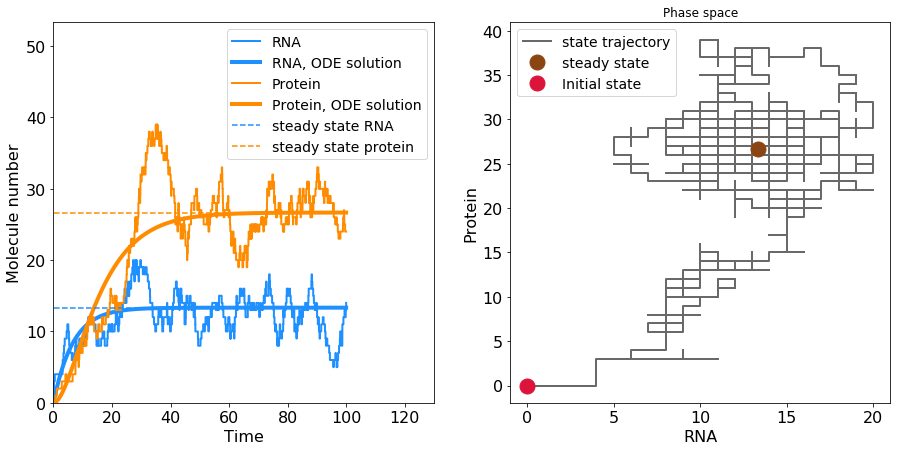

In [20]:
# define parameters and time vector to solve the ODEs
beta = 2
gamma_m = 0.15
k = 0.2
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 0
protein_0 = 0
initial_state = [RNA_0,protein_0]

# simulation time
tf = 100

sim = stoch_sim_transcription_translation(param,initial_state,tf)

# determinisitc simulation
tt = sp.linspace(0,100,200)
y_0 = [RNA_0,protein_0]
sol_deterministic = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

fig,ax = pl.subplots(1,2, figsize = (15,7))
ax[0].plot(sim[:,0],sim[:,1], label = 'RNA', color = color_rna, lw = line_width,drawstyle = 'steps')
ax[0].plot(tt,sol_deterministic[:,0], color = color_rna, lw = 2*line_width, label = 'RNA, ODE solution')
ax[0].plot(sim[:,0],sim[:,2], label = 'Protein', color = color_protein,lw = line_width,drawstyle = 'steps')
ax[0].plot(tt,sol_deterministic[:,1], color = color_protein, lw = 2*line_width, label = 'Protein, ODE solution')
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_RNA,'--', label = 'steady state RNA',
          color = color_rna)
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_protein,'--', label = 'steady state protein',
          color = color_protein)
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Molecule number')
ax[0].set_ylim(0,2*steady_state_protein)
ax[0].set_xlim(0,130)

ax[1].plot(sim[:,1],sim[:,2], label = 'state trajectory', lw = line_width,color = color_phase_space)
ax[1].plot(steady_state_RNA,steady_state_protein,'o',ms = 15,label = 'steady state', color = color_steady_state)
ax[1].plot(RNA_0,protein_0,'o',ms = 15,label = 'Initial state', color = color_initial_state)
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')

# Gene expression noise depends on transcription and translation rates

Due to the stochastic nature of biochemical reactions noise in the expression level of proteins is inherent. The noise level can be tuned by a cell by controlling the transcription and translation rates of a gene. On our simple we want to exemplify the effects on two examples:

1. High transcription rate and low tranlation rate
2. Low transcription rate and High translation rate

The steady state protein level for both cases is the same, but the fluctuations around it are very different. 

**Exercise 8**

Below you find a simulation of our system for the first case with high transcription rate and low translation rate. 
- Create a second realisation with low transcription and high translation rates.
- Estimate the expression noise by means of the Coefficient of variation $CV= \frac{STD}{Mean}$.
- In addition, visualise the variability of the protein level by plotting a histogram of it.

**Questions**
- How should you change the rates to keep the protein steady state fixed?
- Which effect do the inverse changes of the transcription and translation rates have on temporal fluctuations? What did you expect on your previous experience?
- What are mechanisms for a cell to either promote or suppress expression noise?

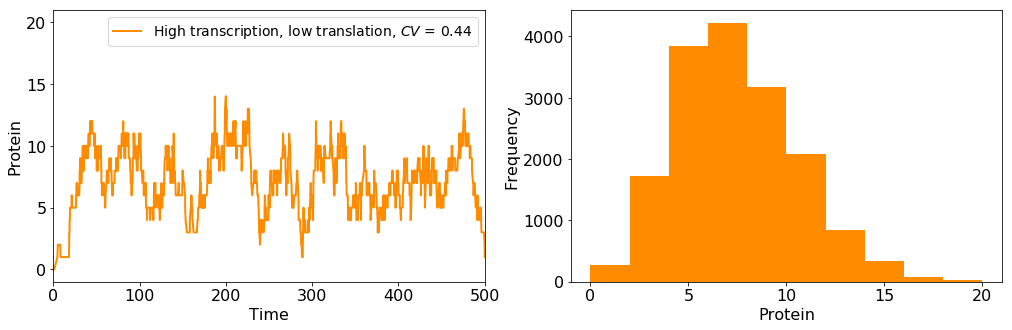

In [21]:
# high transcription rate
beta_high = 1

# low translation rate
k_low = 0.1

# decay rates
gamma_m = 0.15
gamma_p = 0.1

param_beta_high = [beta_high,gamma_m,k_low,gamma_p]

# simulation time
tf = 5000

# set the initial state to the steady state
initial_state_beta_high = [0,0]

# run stochastic simulation
sim_beta_high = stoch_sim_transcription_translation(param_beta_high,initial_state_beta_high,tf)

# calculate coefficient of variation
CV_beta_high = (sim_beta_high[:,2].std()/sim_beta_high[:,2].mean())

fig,ax = pl.subplots(1,2, figsize = (17,5))

ax[0].plot(sim_beta_high[:,0],sim_beta_high[:,2],lw = line_width,color = color_protein, 
           label = 'High transcription, low translation, $CV$ = '+str(np.round(CV_beta_high,2)))
ax[0].set_xlim(0,500)
ax[0].legend(loc = 'best')
ax[0].set_ylabel('Protein')
ax[0].set_xlabel('Time')

ax[1].hist(sim_beta_high[:,2], color = color_protein);
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Protein')

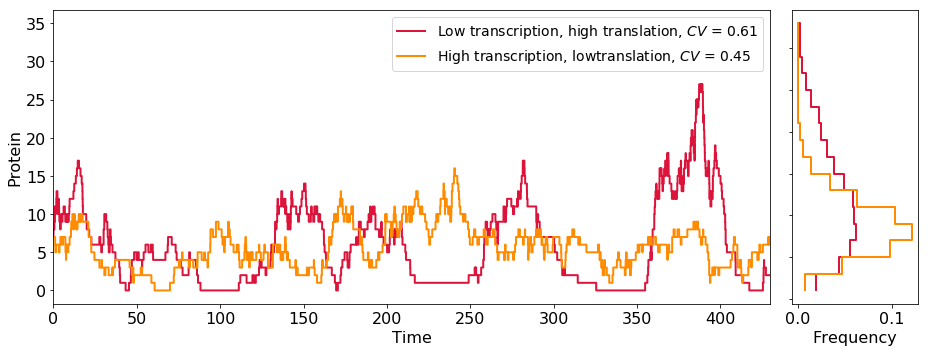

In [22]:
# delete in student version

# define high and low transcripion and translation rates
k_low = 0.1
k_high = 1

beta_low = 0.1
beta_high = 1

gamma_m = 0.15
gamma_p = 0.1

param_beta_low = [beta_low,gamma_m,k_high,gamma_p]
param_beta_high = [beta_high,gamma_m,k_low,gamma_p]

# calculate the steady states from the kinetic parameters
steady_state_protein = k_low*beta_high/gamma_m/gamma_p
steady_state_RNA_low = beta_low/gamma_m
steady_state_RNA_high = beta_high/gamma_m

# simulation time
tf = 5000

# set the initial state to the steady state
initial_state_beta_low = np.round([steady_state_RNA_low,steady_state_protein])
initial_state_beta_high = np.round([steady_state_RNA_high,steady_state_protein])

sim_beta_low = stoch_sim_transcription_translation(param_beta_low,initial_state_beta_low,tf)
sim_beta_high = stoch_sim_transcription_translation(param_beta_high,initial_state_beta_high,tf)

# calculate the noise levels for both simulations
CV_beta_low = (sim_beta_low[:,2].std()/sim_beta_low[:,2].mean())
CV_beta_high = (sim_beta_high[:,2].std()/sim_beta_high[:,2].mean())

# plot results
fig = pl.figure(figsize = (13,5))
gs = gridspec.GridSpec(1,30)

ax = fig.add_subplot(gs[0:25])
ax.plot(sim_beta_low[:,0],sim_beta_low[:,2], lw = line_width, color = color_initial_state,drawstyle = 'steps',
        label = 'Low transcription, high translation, $CV$ = '+str(np.round(CV_beta_low,2)))
ax.plot(sim_beta_high[:,0],sim_beta_high[:,2], lw = line_width, color = color_protein,drawstyle = 'steps',
       label = 'High transcription, lowtranslation, $CV$ = '+str(np.round(CV_beta_high,2)))

ax.legend(loc = 'best')
ax.set_xlim(0,430)
ax.set_ylabel('Protein')
ax.set_xlabel('Time')

ax = fig.add_subplot(gs[25:])
bins = np.arange(0,sim_beta_low[:,2].max(),2)
bin_centers = np.arange(1,sim_beta_low[:,2].max()-1,2)
hist_beta_low = np.histogram(sim_beta_low[:,2],bins = bins, normed = 1)
hist_beta_high = np.histogram(sim_beta_high[:,2],bins = bins, normed = 1)

ax.plot(hist_beta_low[0],bin_centers,lw = line_width, color = color_initial_state,drawstyle = 'steps')
ax.plot(hist_beta_high[0],bin_centers,lw = line_width, color = color_protein,drawstyle = 'steps')

ax.set_xticks([0,0.1])

ax.set_yticklabels([])
ax.set_xlabel('Frequency')

pl.tight_layout()

## Influence of the RNA decay rate on temporal fluctuations

We will run stochastic simulations of the fluctuations around steady state and test the influence of the decay rates of RNA and protein while keeping the steady state constant. First lets start with the influence of the decay rate of the RNA. We define a range of RNA decay rates $\gamma_{m}$ and keep the RNA steady state fixed by adjusting the RNA production rate.

In [23]:
# define kinetic parameters
steady_state_RNA = 10
steady_state_protein = 20

# range of decay rates of the RNA
GAMMA_m = np.array([0.01,0.05,0.1,0.5])
beta = steady_state_RNA * GAMMA_m

gamma_p = k * steady_state_RNA / steady_state_protein

k = 0.2

# set the inital conditions to the steady state
initial_state = np.round([steady_state_RNA,steady_state_protein])

# set the simulation time longer than before for better statistics
tf = 500

# iteration over the defined gamma_m
res = []
for ii,gamma_m in enumerate(GAMMA_m):
    param = [beta[ii],gamma_m,k,gamma_p]
    sim = stoch_sim_transcription_translation(param,initial_state,tf)
    
    res.append(sim)

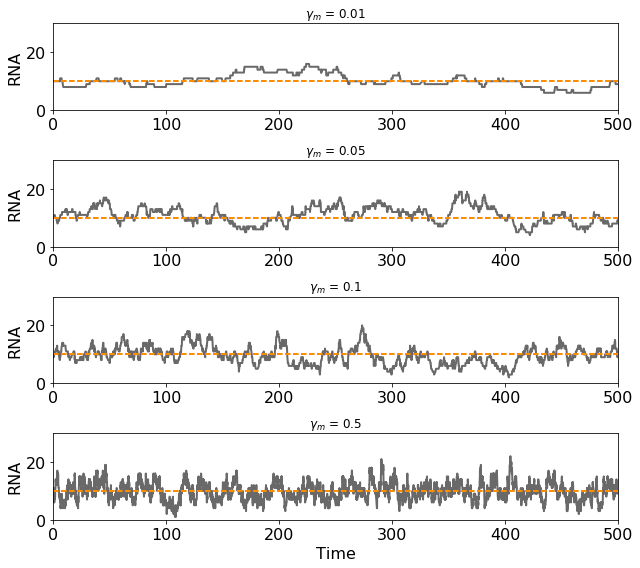

In [24]:
# visualize the results
fig,ax = pl.subplots(len(res),1, figsize = (9,8))

color = 'dimgrey'
color_ss = 'darkorange'
xmin,xmax = 0,tf
ymin_m,ymax_m = 0,30
ymin_p,ymax_p = 0,40

for ii,rr in enumerate(res):
    ax[ii].plot(rr[:,0],rr[:,1],color = color, lw = 2,
               label = '$\gamma_{m}$ = '+str(GAMMA_m[ii]))
    ax[ii].plot([0,tf],[steady_state_RNA,steady_state_RNA],'--',lw = 2, color = color_ss)
    ax[ii].set_ylim(ymin_m,ymax_m)
    ax[ii].set_xlim(xmin,xmax)
    ax[ii].set_ylabel('RNA')
    ax[ii].set_title('$\gamma_{m}$ = '+str(GAMMA_m[ii]))
    
ax[ii].set_xlabel('Time')
    
pl.tight_layout()